## make sure you are using the environment: Python conda env:notebook

# Exploring sea ice freeboards with ICESat-2 (ATL10)

Information obtained primarily from the ATL07/10 Algorithm Theoretical Basis Document (ATBD, Kwok et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl10.   

Notebook author: Alek Petty, relying extensively on above product manuals. 
Description: Notebook describing the ICESat-2 ATL10 product.   
Input requirements: Demo ATL10 data file   
Date: June 2019
More info: See the ATL07/ATL10 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL07_ATL10_ATBD_r001.pdf   


## Notebook objectives
* General understanding of what's included in a typical ATL10 file.
* Plotting and basic analysis of ATL10 data.
* Potentially some info on reading in and analyzing a large quantity of ATL10 data!


## Notebook instructions
1. Follow along with the notebook tutorial. 
2. Play around changing options and re-running the relevant notebook cells. 

Here I use the hdf5 file from: https://nsidc.org/data/atl10  
For the demo below I'm using the file: ATL10-01_20181115003141_07240101_001_01.h5   
If using this using the ICESAT-2 Pangeo instance, you can download the file using the cell below


### Notes      
* Check out the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL0710-KnownIssues.pdf



## ATL10 Background

ATL10 is a pretty simple product, with most of the hard work done in ATL03/07. ATL10 essentially returns the freeboard of the height segments calculated in ATL07 - the difference in height between the ice and sea surface (a mean sea surface height is calculated within 10 km along-track sections from all relevant sea surface heights for each beam). 

A lot of the important variables in ATL07 have been passed through to ATL10 making this a useful high-level data product of interest to the community.

In [17]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [29]:
import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import h5py
import xarray as xr
import utils as ut
from astropy.time import Time


#### Beam selection   
There are 6 beams to choose from in the ICESat-2 products (3 pairs of a strong and weak beam). The energy ratio between the weak and strong beams are  approximately 1:4 and are separated by 90 m in the across-track direction. The beam pairs are separated by ~3.3 km in the across-track direction, and the strong and weak beams are separated by ~2.5 km in the along-track direction.

In [19]:
beamStr='gt1r'

In [21]:
data_loc='/home/jovyan/tutorial-data/sea-ice/'
fname='ATL10-01_20181115003141_07240101_002_01.h5'

In [22]:
f = h5py.File(data_loc+fname, 'r')
fileT= data_loc+fname

In [23]:
def getATL10data(fileT, beam='gt1r', maxFreeboard=10):
    """ Pandas/numpy ATL10 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)

	I've picked out the variables from ATL10 I think are of most interest to sea ice users, 
    but by no means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL10 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you might want
    
	Args:
		fileT (str): File path of the ATL10 dataset
		beamStr (str): ICESat-2 beam (the number is the pair, r=strong, l=weak)
        maxFreeboard (float): maximum freeboard (meters)

	returns:
        pandas dataframe

	"""

    print('ATL10 file:', fileT)
    
    f1 = h5py.File(fileT, 'r')
    
    freeboard=f1[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:]

    freeboard_confidence=f1[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_confidence'][:]
    freeboard_quality=f1[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_quality_flag'][:]
    
    # Delta time in gps seconds
    delta_time = f1[beam]['freeboard_beam_segment']['beam_freeboard']['delta_time'][:]
    # Height segment ID (10 km segments)
    height_segment_id=f1[beam]['freeboard_beam_segment']['beam_freeboard']['height_segment_id'][:]
    
    lons=f1[beam]['freeboard_beam_segment']['beam_freeboard']['longitude'][:]
    lats=f1[beam]['freeboard_beam_segment']['beam_freeboard']['latitude'][:]
    deltaTimeRel=delta_time-delta_time[0]
    
    # #Add this value to delta time parameters to compute full gps_seconds
    atlas_epoch=f1['/ancillary_data/atlas_sdp_gps_epoch'][:] 
    
    leapSecondsOffset=37
    gps_seconds = atlas_epoch[0] + delta_time - leapSecondsOffset
    # Use astropy to convert from gps time to datetime
    tgps = Time(gps_seconds, format='gps')
    tiso = Time(tgps, format='datetime')
    tiso
    # Conversion of delta_time to a calendar date
    #temp = ut.convert_GPS_time(atlas_epoch[0] + deltaTime, OFFSET=0.0)
    
    
    #year = temp['year'][:].astype('int')
    #month = temp['month'][:].astype('int')
    #day = temp['day'][:].astype('int')
    #hour = temp['hour'][:].astype('int')
    #minute = temp['minute'][:].astype('int')
    #second = temp['second'][:].astype('int')
    #dFtime=pd.DataFrame({'year':year, 'month':month, 'day':day, 
    #                    'hour':hour, 'minute':minute, 'second':second})
    

    dF = pd.DataFrame({'freeboard':freeboard, 'lon':lons, 'lat':lats, 'delta_time':delta_time,'deltaTimeRel':deltaTimeRel, 
                     'height_segment_id':height_segment_id,'datetime': tiso})
    
    def getMonth(x):
        return x.to_datetime().month

    dF['month'] = dF['datetime'].apply(getMonth)
    
    #dF['months'] = pd.Series(months, index=dF.index)
    dF = dF[(dF['freeboard']>0)]
    dF = dF[(dF['freeboard']<maxFreeboard)]
    # Decide here if we want to also filter based on the confidence and/or quality flag
    
    # Reset row indexing
    dF=dF.reset_index(drop=True)

    return dF

#### Read in the data using the pandas reader above. Copied from the readers.py script.

Take a look at the top few rows (change the number in head to increase this..)


In [24]:
dF10 = getATL10data(fileT, beam=beamStr)
dF10.head()

ATL10 file: ../../shared/sea-ice/ATL10-01_20181115003141_07240101_002_01.h5


,freeboard,lon,lat,delta_time,deltaTimeRel,height_segment_id,datetime,month
0,0.077381,-168.648556,73.745906,2.747826e+07,219.501606,969,2018-11-15 00:50:58.225562,11
1,0.070254,-168.648610,73.746011,2.747826e+07,219.503267,970,2018-11-15 00:50:58.227223,11
2,0.029698,-168.648625,73.746040,2.747826e+07,219.503734,971,2018-11-15 00:50:58.227690,11
3,0.023347,-168.648647,73.746084,2.747826e+07,219.504422,972,2018-11-15 00:50:58.228379,11
4,0.014431,-168.648718,73.746222,2.747826e+07,219.506628,976,2018-11-15 00:50:58.230584,11


#### Map the data for visual inspection using Cartopy 
*NB (Basemap is often used for mapping but is not being officially supported by the community anymore)*

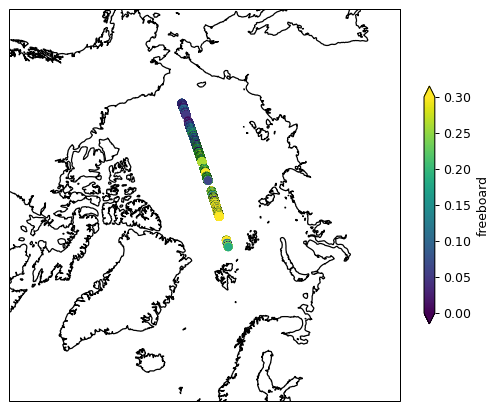

In [25]:
var='freeboard'
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
# ccrs.PlateCarree
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF10['lon'], dF10['lat'],c=dF10[var], cmap='viridis', vmin=0, vmax=0.3, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

#### Apply Warren snow depth and density data 
Below function adds data from function fits for the given time/location of each freeboard point


In [26]:
# Add this to the dataframe
dF10=ut.getWarrenData(dF10, 'snowDepthW99', outDensityVar='snowDensityW99')
dF10.head()

,freeboard,lon,lat,delta_time,deltaTimeRel,height_segment_id,datetime,month,snowDepthW99,snowDensityW99
0,0.077381,-168.648556,73.745906,2.747826e+07,219.501606,969,2018-11-15 00:50:58.225562,11,0.184167,286.037556
1,0.070254,-168.648610,73.746011,2.747826e+07,219.503267,970,2018-11-15 00:50:58.227223,11,0.184168,286.037480
2,0.029698,-168.648625,73.746040,2.747826e+07,219.503734,971,2018-11-15 00:50:58.227690,11,0.184168,286.037459
3,0.023347,-168.648647,73.746084,2.747826e+07,219.504422,972,2018-11-15 00:50:58.228379,11,0.184169,286.037427
4,0.014431,-168.648718,73.746222,2.747826e+07,219.506628,976,2018-11-15 00:50:58.230584,11,0.184170,286.037327


#### Convert to thickness using the Warren snow depth/density...

In [27]:
dF10=ut.getSnowandConverttoThickness(dF10, snowDepthVar='snowDepthW99', 
                                 snowDensityVar='snowDensityW99',
                                 outVar='iceThickness')
dF10.head()

,freeboard,lon,lat,delta_time,deltaTimeRel,height_segment_id,datetime,month,snowDepthW99,snowDensityW99,iceThickness
0,0.077381,-168.648556,73.745906,2.747826e+07,219.501606,969,2018-11-15 00:50:58.225562,11,0.184167,286.037556,0.223574
1,0.070254,-168.648610,73.746011,2.747826e+07,219.503267,970,2018-11-15 00:50:58.227223,11,0.184168,286.037480,0.202984
2,0.029698,-168.648625,73.746040,2.747826e+07,219.503734,971,2018-11-15 00:50:58.227690,11,0.184168,286.037459,0.085807
3,0.023347,-168.648647,73.746084,2.747826e+07,219.504422,972,2018-11-15 00:50:58.228379,11,0.184169,286.037427,0.067457
4,0.014431,-168.648718,73.746222,2.747826e+07,219.506628,976,2018-11-15 00:50:58.230584,11,0.184170,286.037327,0.041696


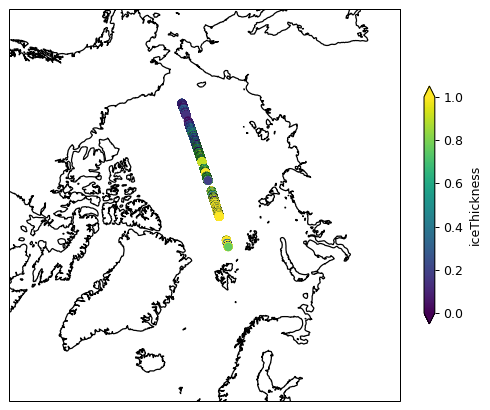

In [28]:
# Map the data for visual inspection usign Cartopy
var='iceThickness'
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF10['lon'], dF10['lat'],c=dF10[var], cmap='viridis', vmin=0, vmax=1, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

### Extra ideas

1. Check beam consistency!
2. Look at the high-res thickness distribution. How do the histograms look?
3. Add your favourite (clearly NESOSIM) snow depth and density data and assess thicknesses. 

#### As part of the project science office activities we've been producing a semi-official sea ice thickness product using ATL10 and snow loading from the NESOSIM snow model

You can access one week of November high-res thickness data here: https://drive.google.com/file/d/1tN3qL0rBq2r1mJT00VFB9hQpHASKq7C5/view?usp=sharing   

I have provided a batch reader function for this data in utils.py: getProcessedATL10ShotdataNCDF so I encourage you to use that and try and generate some thickness plots.   

The thickness data include various estimates based on different uses of the snow loading (products and redistribution). This is still work in progress so I can't provide too mnay more official details yet!